# Modeling number of emails received with MCMC

#### Mimoun Cadosch Delmar 
#### 6/2017

In [2]:
import pandas as pd
from IPython.core.pylabtools import figsize
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np

### Read / plot data
Read mom's emails

In [3]:
data = pd.read_pickle('data/mom_emails')

In [4]:
data.head(n=3)

,emails,dates
0,6,2008-Aug
1,4,2008-Jul
2,3,2008-Jun


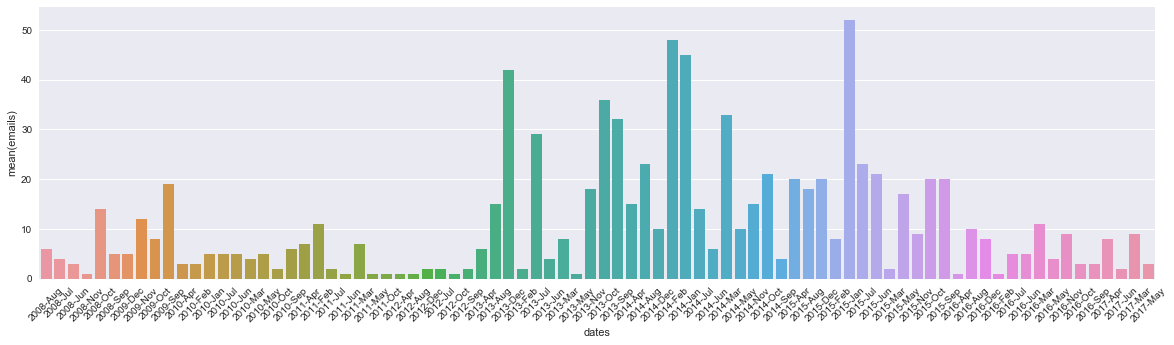

In [5]:
# Plot email data
figsize(20, 5)
ax = sns.barplot(x="dates", y="emails", data=data)
for item in ax.get_xticklabels():
    item.set_rotation(45)
plt.show()

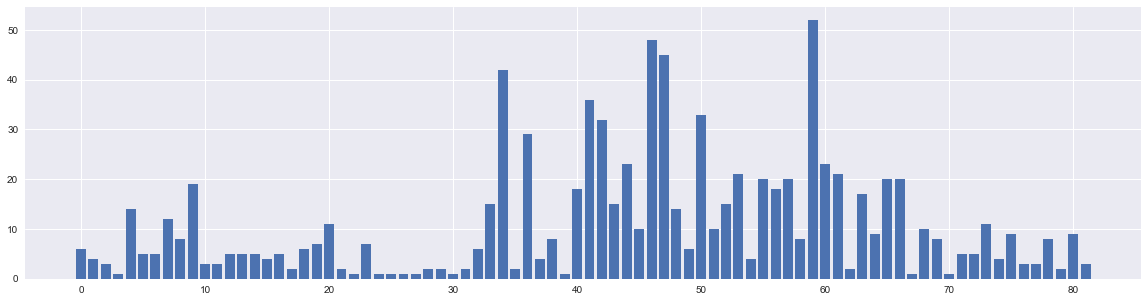

In [6]:
n_dates = len(data)
np.arange(n_dates)
plt.bar(np.arange(n_dates), list(data.emails))
plt.show()

### Distribution

We model the probability of getting an email in a given day with a random variable following a poisson distribution with parameter $\lambda$. In other words:

$$C_i \sim Poisson(\lambda)$$

Moreover, since we observe that we receive more emails after a given point in time $\tau$, we want to model the parameter $\lambda$ as changing at $\tau$, from $\lambda_1$ to $\lambda_2$.

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

Additionally, the parameter $\lambda$ to the $C_i$ random variable can be modeled as a random variable itself. Moreover, the $\lambda$ random variable can be modeled using an exponential distribution. We need $\lambda$ to be continuous and positive, and the expontential distribution provides positive values from a continuous range. The exponential distribution, in turn, is parametrized by $\alpha$. 

$\lambda_1 \sim Exp(\alpha)$  
$\lambda_2 \sim Exp(\alpha)$

A good rule of thumb for setting the parameter of an exponential distribution:
$$
\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}
$$

Moreover, we have no strong beliefs about where $\tau$ is, so we model it with a uniform distribution.
$\tau = Discrete\_Uniform(1, n_dates)$

In [7]:
alpha = 1.0 / data.emails.mean()

lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=len(data))

In [8]:
print "Random output:", tau.random(), tau.random(), tau.random()

Random output: 52 21 16


In [9]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(len(data))
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

In [10]:
observation = pm.Poisson("obs", lambda_, value=data.emails, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

In [11]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

 [-----------------100%-----------------] 40000 of 40000 complete in 6.5 sec

In [12]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

### Posterior distributions
Here we show the posterior distributions of $\lambda_1$ and $\lambda_2$, after the Monte Carlo Markov Chain sampling from the posterior distribution.

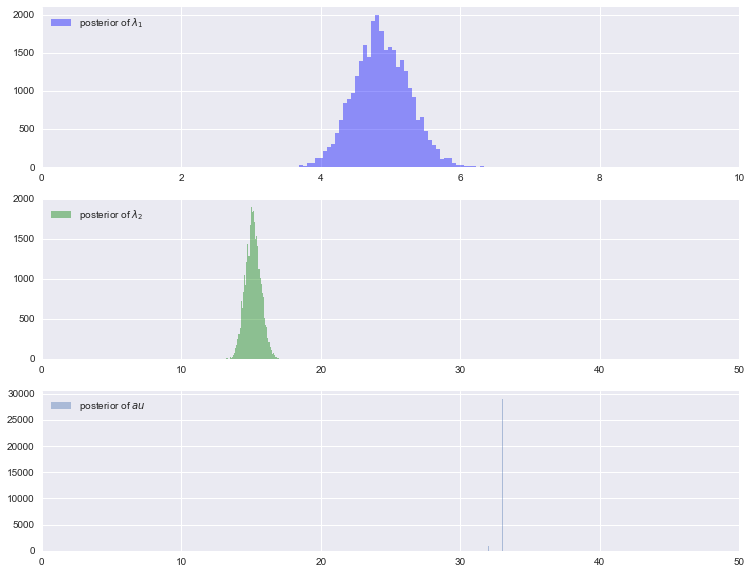

In [13]:
# Histogram of posterior distributions

figsize(12.5, 10)

ax1 = plt.subplot(311)

sns.distplot(lambda_1_samples, ax=ax1, label="posterior of $\lambda_1$", color="blue", kde=False)
ax1.legend(loc="upper left")
ax1.set_xlim([0, 10])

ax2 = plt.subplot(312)
sns.distplot(lambda_2_samples, ax=ax2, label="posterior of $\lambda_2$", color="green", kde=False)
ax2.legend(loc="upper left")
ax2.set_xlim([0, 50])

ax3 = plt.subplot(313)
sns.distplot(tau_samples, ax=ax3, label="posterior of $\tau$", kde=False)
ax3.legend(loc="upper left")
ax3.set_xlim([0, 50])

plt.show()

In [22]:
## Expected number of emails per day 

# for day in range(0, len(data)):
# tau_samples  

In [23]:
0 < tau_samples

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [24]:
a = np.array([True, True, False])
len(a[a == True])

2

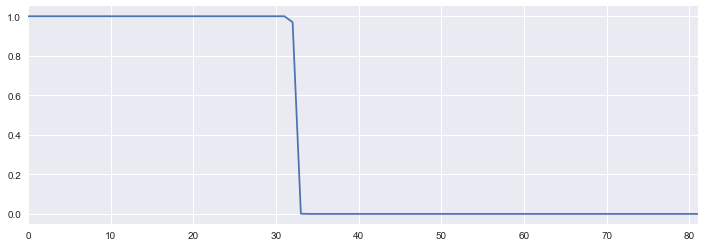

In [25]:
figsize(12, 4)
# Probability that day before switchpoint value tau
probs_day_before_tau = np.zeros(len(data.emails))
for day in range(0, len(data.emails)):
    # Probability of day being before tau
    ix = day < tau_samples
    probs_day_before_tau[day] = float( len( ix[ix==True]) ) / len(ix)
    
sns.tsplot(probs_day_before_tau)
plt.show()

In [31]:
len(data.emails)

82

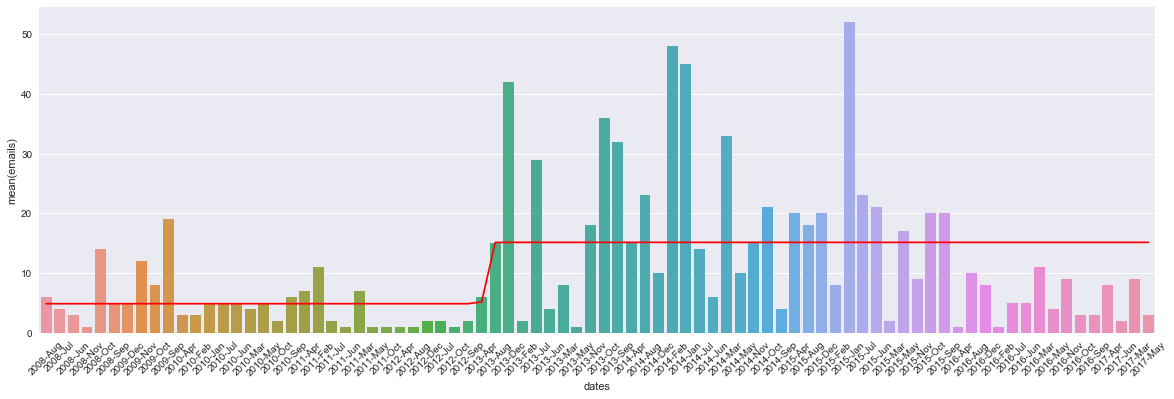

In [40]:
# Expected number of emails
expected_emails_per_day = np.zeros(len(data.emails))
realization = np.zeros(len(data.emails))
N = tau_samples.shape[0]

for day in range(0, len(data.emails)):
    ix = day < tau_samples
    # Depending on the day, expected value of emails is the weighted expected value from two posterior distributions. 
    # Weighting is done with posterior probability of tau being before or after day (see previous chart)
    expected_emails_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N

figsize(20, 6)
fig, ax = plt.subplots()
sns.tsplot(expected_emails_per_day, ax=ax, color='red')
sns.barplot(x="dates", y="emails", data=data, ax=ax)
for item in ax.get_xticklabels():
    item.set_rotation(45)
plt.show()

## Create new dataset by retelling the story, reversing the steps

In [31]:
n_data = len(data)

In [32]:
tau = pm.rdiscrete_uniform(0, n_data)
print tau

7


In [33]:
emails_mean = data.emails.mean()
alpha = 1. / emails_mean
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print(lambda_1, lambda_2)

(8.4311281426709019, 6.527883845666862)


In [34]:
new_data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, n_data - tau)]

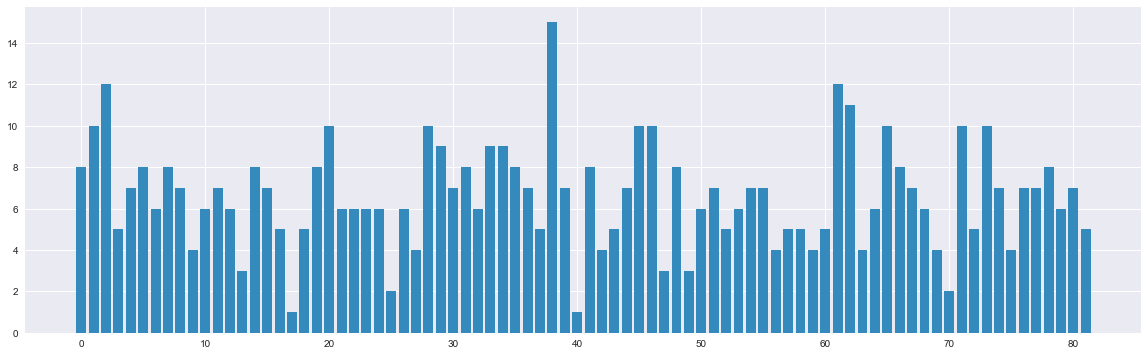

In [35]:
plt.bar(np.arange(len(new_data)), new_data, color="#348ABD")
plt.show()